# Figure. CNV eQTL Characteristics

In [1]:
import copy
import cPickle
import os
import subprocess

import cdpybio as cpb
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pybedtools as pbt
import scipy.stats as stats
import seaborn as sns

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_cnv_eqtl_characteristics'
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)

Each figure should be able to fit on a single 8.5 x 11 inch page. Please do not send figure panels as individual files. We use three standard widths for figures: 1 column, 85 mm; 1.5 column, 114 mm; and 2 column, 174 mm (the full width of the page). Although your figure size may be reduced in the print journal, please keep these widths in mind. For Previews and other three-column formats, these widths are also applicable, though the width of a single column will be 55 mm.

In [19]:
fn = os.path.join(ciepy.root, 'output', 'mcnv_analysis', 'sig.tsv')
mcnv_sig = pd.read_table(fn, index_col=0)

In [2]:
fn = os.path.join(ciepy.root, 'output/cnv_analysis/cnv_gene_variants.pickle')
cnv_gv = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'output/cnv_analysis/combined_info.pickle')
combined_info = cPickle.load(open(fn))

sig_cnvs = set(cnv_gv.cnv_id)
not_sig_cnvs = set(combined_info.index) - sig_cnvs

In [14]:
cnv_lead_vars = cnv_gv[cnv_gv.cnv_is_lead]
cnv_lead_vars = cnv_lead_vars.sort_values(by='pvalue').drop_duplicates(subset=['gene_id'])

In [16]:
p = sum(cnv_lead_vars.beta > 0) / float(cnv_lead_vars.shape[0])
print('{:.2f}% of lead CNV eQTLs are positively associated with gene expression.'.format(p * 100))

81.98% of lead CNV eQTLs are positively associated with gene expression.


In [3]:
sns.set_style('whitegrid')

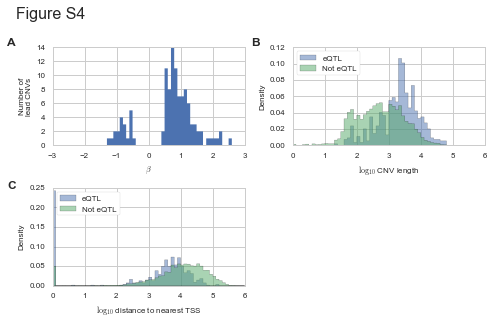

In [22]:
fig = plt.figure(figsize=(6.85, 4.5), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 0, 'Figure S4',
        size=16, va='bottom')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

gs = gridspec.GridSpec(2, 2)

# SNV/indel vs. CNV effect size
ax = fig.add_subplot(gs[0, 0])
cnv_abs_beta_pdf.plot(label='CNV', ax=ax, linestyle='--')
snv_abs_beta_pdf.plot(label='Not CNV', ax=ax)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\left|\\beta\\right|$', fontsize=8)
ax.set_ylabel('Density', fontsize=8)
ax.legend(fontsize=7, frameon=True, fancybox=True)
gs.tight_layout(fig, rect=[0, 0.55, 0.5, 0.77])

# Length
ax = fig.add_subplot(gs[0, 1])

se = np.log10(combined_info.ix[sig_cnvs, 'svlen'].abs())
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))

se = np.log10(combined_info.ix[not_sig_cnvs, 'svlen'].abs())
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='Not eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))
ax.legend(fontsize=8, loc='upper left', fancybox=True, frameon=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\log_{10}$ CNV length', fontsize=8)
ax.set_ylabel('Density', fontsize=8)

# TSS distance.
ax = fig.add_subplot(gs[1, 0])

se = np.log10(combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs() + 1)
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))

se = np.log10(combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs() + 1)
weights = np.ones_like(se) / float(se.shape[0])
se.hist(ax=ax, label='Not eQTL'.format(se.shape[0]), 
        alpha=0.5, weights=weights, histtype='stepfilled',
        bins=np.arange(0, 6.1, 0.1))
ax.legend(fontsize=8, loc='upper left', fancybox=True, frameon=True)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\log_{10}$ distance to nearest TSS', fontsize=8)
ax.set_ylabel('Density', fontsize=8)

# Lead CNV effect sizes
ax = fig.add_subplot(gs[0, 0])
bins = np.arange(-3, 3.1, 0.1)
cnv_lead_vars.drop_duplicates('gene_id').beta.hist(bins=bins, histtype='stepfilled', lw=0)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(8)
ax.set_xlabel('$\\beta$', fontsize=8)
ax.set_ylabel('Number of\nlead CNVs', fontsize=8)
ax.set_xlim(-3, 3)

# # TSS distance without overlaps.
# ax = fig.add_subplot(gs[1, 0])
# a = combined_info.ix[sig_cnvs, 'nearest_tss_dist'].abs()
# a = a[a != 0]
# se = np.log10(a.abs())
# weights = np.ones_like(se) / float(se.shape[0])
# se.hist(ax=ax, label='eQTL'.format(se.shape[0]), 
#         alpha=0.5, weights=weights, histtype='stepfilled',
#         bins=np.arange(0, 6.1, 0.1))

# b = combined_info.ix[not_sig_cnvs, 'nearest_tss_dist'].abs()
# b = b[b != 0]
# se = np.log10(b.abs())
# weights = np.ones_like(se) / float(se.shape[0])
# se.hist(ax=ax, label='Not eQTL'.format(se.shape[0]), 
#         alpha=0.5, weights=weights, histtype='stepfilled',
#         bins=np.arange(0, 6.1, 0.1))
# ax.legend(fontsize=8, loc='upper left', fancybox=True, frameon=True)
# for t in ax.get_xticklabels() + ax.get_yticklabels():
#     t.set_fontsize(8)
# ax.set_xlabel('$\\log_{10}$ distance to nearest TSS', fontsize=8)
# ax.set_ylabel('Density', fontsize=8)

t = fig.text(0.005, 0.86, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.86, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.42, 'C', weight='bold', 
             size=12)

gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig(os.path.join(outdir, 'cnv_eqtl_chars.pdf'))
fig.savefig(os.path.join(outdir, 'cnv_eqtl_chars.png'), dpi=300)